# Notebook preprocessing
**IMTA S5 TAF Health**

Pre-processing notebook to create set of non-pathological and pathological patches using mammography images. 

Author : AriasC. 2020. CiGAN2

In [1]:
#import shutil
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches
import os
from scipy import ndimage

### to update from tf1 to tf2

In [7]:
tf_upgrade_v2 \
  --intree ./ \
  --outtree ./p2/ \
  --reportfile report.txt

---
# 1. Creation of the dataset
## move images to 'cancer' and 'nocancer' folders
---

In [10]:
path = '../inbreast-all-2048-1024/' #images
cancer = []
nocancer = os.listdir(path)
for c in os.listdir(path):
    #get name's mask
    if (c.split('-')[-1][:-4]) == 'mask':
        #add name of mask
        cancer.append(c)
        #create name of image         
        name = "{}-{}.png".format(c.split('-')[0],c.split('-')[1])
        cancer.append(name)
        nocancer.remove(c)
        nocancer.remove(name)
len(cancer)


214

In [9]:
len(nocancer)

303

In [12]:
#make dirs
npath = '../dataset/'
os.makedirs(npath + 'cancer',exist_ok=True)
os.makedirs(npath + 'nocancer',exist_ok=True)

In [16]:
from shutil import copyfile
from tqdm import tqdm

In [17]:
for i in tqdm(cancer):
    copyfile(path + i, npath + 'cancer/' + i)  

100%|██████████| 214/214 [00:01<00:00, 181.05it/s]


In [18]:
for i in tqdm(nocancer):
    copyfile(path + i, npath + 'nocancer/' + i)  

100%|██████████| 303/303 [00:02<00:00, 138.00it/s]


# patches

Plot region and properties from the mask

(2048, 1024)
Area [179639], centroid [(1023.4010487700332, 272.1344975200263)]
144 895 63469 1


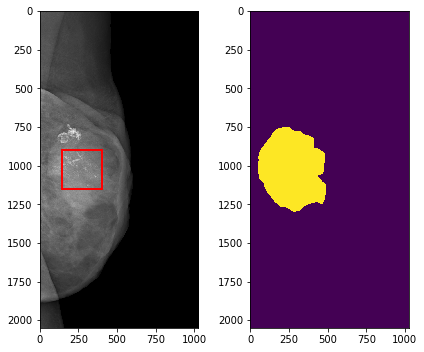

In [20]:
img_file = '../inbreast-all-2048-1024/53582656-LMLO.png'
mask_file = '../inbreast-all-2048-1024/53582656-LMLO-mask.png'
plot_image(img_file,mask_file)


### make patches

In [2]:
def get_limits(centroid, patch_size = 256):
    """Calculate the starting point of the patch, this point 
    has as limits: (0,0) - (ymax,xmax).
    Where: 
        'ymax' = number of rows - patch_size 
        'xmax' = number of columns - patch_size
        'limit' = middle of the patch
        
    X: 1024 (columns) et Y: 2048 (rows) 
    Parameters
    ----------
    centroid : (int,int)
        Coordinates of the centroid of the lesion, (row,column)
    """
    lim = patch_size//2      
    xmax = 1024 - patch_size
    ymax = 2048 - patch_size
    yy,xx = centroid
    # min left (0,0)
    x = 0 if (xx - lim) < 0 else int((xx - lim))
    y = 0 if (yy - lim) < 0 else int((yy - lim))
    # max patch at (ymax,xmax)
    x = x if (xx - lim) < xmax else xmax
    y = y if (yy - lim) < ymax else ymax
    return x,y

In [3]:
def make_patch_cancer(img_file,mask_file, plot = False,patch_size = 256):
    """ Function to create a 256x256 patch in the real image and in the mask image. 
    This patch is centered in the centroid of the area of the lesion,  
    the starting point is calculated by using 'get_limits' function.
   
    Parameters
    ----------
    img_file : str
        The path of the real image
    mask_file : str
        The path of the mask
    plot : bool, optional
        Show the patch and the mask, default is False

    Returns
    ------
    x_real, x_mask
        dimensions(1,256*256) each one.
    """
    #load image and mask
    img_    = io.imread(img_file, as_gray = True) 
    mask = io.imread(mask_file).astype(np.uint8)//255   #[0-1]
    #convert mask to labels
    label_img = label(mask)
    if plot:
        fig, ax = plt.subplots(1,2)
    #detects regions
    for region in regionprops(label_img):
        print("Area {}".format(region.area))
        if region.area > ((256*256) - 10000):
            print("***********Area bigger than the limit,resized****")
            minr, minc, maxr, maxc = region.bbox
            patch_size = np.maximum((maxc-minc)+100,(maxr-minr)+100)
            #get the starting point of the patch
            r,c = region.centroid
            # moves the starting point at centroid - 50
            x,y = get_limits((r - 50,c - 50),patch_size)
            x_real = img_[y:y+patch_size,x:x+patch_size]
            x_mask = mask[y:y+patch_size,x:x+patch_size] 
            #resize to 256
            x_real = ndimage.zoom(x_real , (256/patch_size))
            x_mask = ndimage.zoom(x_mask , (256/patch_size))
        else:
            x,y = get_limits(region.centroid)        
            x_real = img_[y:y+patch_size,x:x+patch_size]
            x_mask = mask[y:y+patch_size,x:x+patch_size] 
        
        if plot:
            ax[0].imshow(x_real)
            ax[1].imshow(x_mask,vmin=0,vmax=1)
    if plot:
        plt.tight_layout()
        plt.show()
    return x_real.flatten(),x_mask.flatten()  
    

Area 179639
***********Area bigger than the limit,resized****


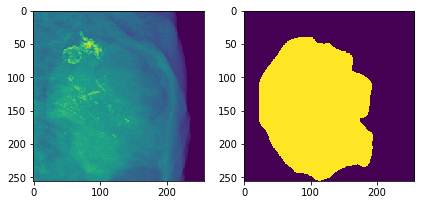

(65536,)

In [6]:
img_file = './inbreast-all-2048-1024/53582656-LMLO.png'
mask_file = './inbreast-all-2048-1024/53582656-LMLO-mask.png'
#plot_image(img_file,mask_file)
X,Y = make_patch_cancer(img_file,mask_file,True)
X.shape

## saveImages

In [ ]:
path = '../dataset/cancer/'
X = [] #imreal
Y = [] #mask
from tqdm import tqdm
for c in tqdm(os.listdir(path)):
    if (c.split('-')[-1][:-4]) == 'mask':
        im = "{}{}-{}.png".format(path,c.split('-')[0],c.split('-')[1])
        x,y = make_patch_cancer(im,path+c,False) #no plot
        X.append(x)
        Y.append(y)
        print(x.shape,y.shape,c.split('-')[0])


# patches.npz

In [8]:
#save data
np.savez_compressed('../patches', x_real = np.stack(X), x_mask = np.stack(Y))

At this point the dataset of patches was made and saved in 'patches.npz'. The dataset is composed by:
----

- x_real : [107, 256*256]
- x_mask : [107, 256*256] 



---
# 2. Experiments with ciGAN
---


# (*) demo one image from our dataset

In [2]:
patch_size = 256
combined_dims = 4
#dataset made in the first part 
X_group = np.load('../patches.npz')
print("Variables in the dataset[{}]\n".format(X_group.files))

Variables in the dataset[['x_mask', 'x_real']]



In [3]:
[X_group[x].shape for x in X_group.files]

[(107, 65536), (107, 65536)]

### visualization

**Note** method to normalize using min and max


In [5]:
def normalize(img):
    return (img - img.min())/(img.max()-img.min())

In [8]:
import scipy.misc as misc
import scipy.ndimage.morphology as morph
import scipy.ndimage.filters as filters

Soit $X$ une figure et $B$ un élément structurant. L'érosion de $X$ par $B$ est l'ensemble des pixels $p$ tels que la fenêtre $Bp$ est incluse dans $X$ :

$$ ErosB(X) = {p | Bp X}$$
L'effet de l'érosion est d'abord de rétrécir la figure.

Conclusion:
According to [mammo's] structure, the training data are TENSOR with shape of `[patch_size,patch_size,1]` so 


In [14]:

X_mask = X_group['x_mask'][0].reshape((patch_size, patch_size))
X_real = normalize(X_group['x_real'][0].reshape((patch_size, patch_size)))
X_rand = np.random.uniform(0, 1, X_mask.shape)*X_mask
X_corrupt = (np.multiply(X_real, np.logical_not(X_mask).astype(int))+X_rand)
boundary = np.multiply(np.invert(morph.binary_erosion(X_mask)), X_mask)
X_boundary = normalize(filters.gaussian_filter(255.0*boundary,10)).reshape((patch_size, patch_size, 1))

X_combined = np.concatenate((X_corrupt.reshape(patch_size, patch_size, 1), 
                             X_mask.reshape(patch_size, patch_size, 1),
                             X_real.reshape(patch_size, patch_size, 1),
                             X_boundary), 
                            axis=-1)
print("Each one {}, changes in the method getcpacthes".format(X_combined.shape))

Each one (256, 256, 4), changes in the method getcpacthes


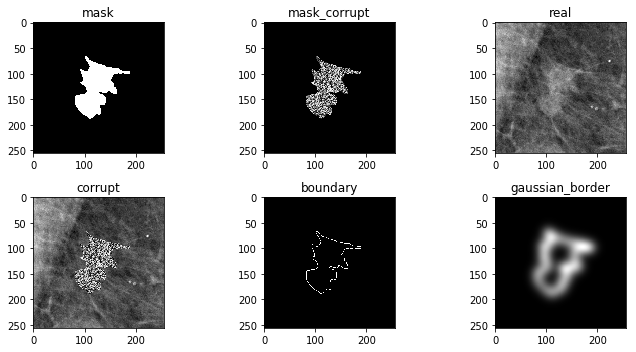

In [15]:
#-----------------------------plot
fig, ax = plt.subplots(2,3,figsize=(10,5))
img = [X_mask,X_rand,X_real,X_corrupt,boundary,X_boundary[:,:,0]]
labels = ['mask','mask_corrupt','real','corrupt','boundary','gaussian_border']
for i,x in enumerate(img):   
    ax[i//3,i%3].imshow(x,cmap = 'gray',vmin=0,vmax=1)
    ax[i//3,i%3].set_title(labels[i])
plt.tight_layout()
plt.show()
#-----------------------------plot

In [16]:
index = 10
X_mask = X_group['x_mask'][index].reshape((patch_size, patch_size))
X_real = normalize(X_group['x_real'][index].reshape((patch_size, patch_size)))
X_rand = np.random.uniform(0, 1, X_mask.shape)*X_mask
X_corrupt = (np.multiply(X_real, np.logical_not(X_mask).astype(int))+X_rand)
boundary = np.multiply(np.invert(morph.binary_erosion(X_mask)), X_mask)
X_boundary = normalize(filters.gaussian_filter(255.0*boundary,10)).reshape((patch_size, patch_size, 1))

X_combined = np.concatenate((X_corrupt.reshape(patch_size, patch_size, 1), 
                             X_mask.reshape(patch_size, patch_size, 1),
                             X_real.reshape(patch_size, patch_size, 1),
                             X_boundary), 
                            axis=-1)
print("Each one {}, changes in the method getcpacthes".format(X_combined.shape))

Each one (256, 256, 4), changes in the method getcpacthes


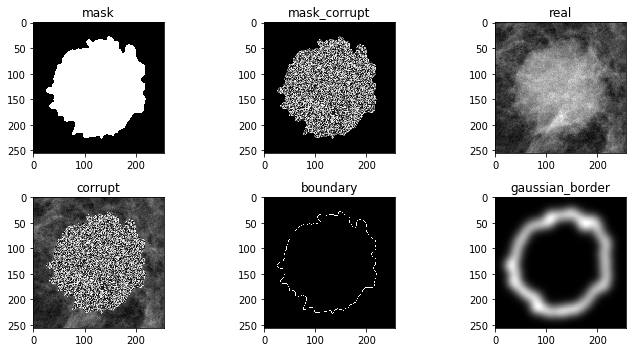

In [17]:
#-----------------------------plot
fig, ax = plt.subplots(2,3,figsize=(10,5))
img = [X_mask,X_rand,X_real,X_corrupt,boundary,X_boundary[:,:,0]]
labels = ['mask','mask_corrupt','real','corrupt','boundary','gaussian_border']
for i,x in enumerate(img):   
    ax[i//3,i%3].imshow(x,cmap = 'gray',vmin=0,vmax=1)
    ax[i//3,i%3].set_title(labels[i])
plt.tight_layout()
plt.show()
#-----------------------------plot

# dataset non-pathological
 
test data
____

In [163]:
def make_patch_non_cancer(img_file, plot = False,patch_size = 256):
    """ Function to make random patches in a non-pathological   
    Parameters
    ----------
    img_file : str
        The path of the real image
    plot : bool, optional
        Show the patch and the mask, default is False

    Returns
    ------
    x_real 
        dimensions(1,256*256) each one. Patch of non-path
    """
    #load image and mask
    img_    = io.imread(img_file, as_gray = True) 
    mask = np.where(img_ == 0,0,1) 
    #convert mask to labels
    label_img = label(mask)
    
    if plot:
        fig, ax = plt.subplots(1,2)
    
    #detects regions
    for region in regionprops(label_img):
        if region.area > 50000:
            print("Area {}".format(region.area))
            minr, minc, maxr, maxc = region.bbox
            #get a patch valid (inside of mask)
            is_valid = False

            #-------- get x,y valid to make a patch
            while not is_valid:
                r = np.random.randint(minr,maxr,1)[0] #random row
                c = np.random.randint(minc,maxc,1)[0] #random column
                x,y = get_limits((r,c),patch_size) #inside ?
                in_mask = np.mean(mask[y:y+patch_size,x:x+patch_size]) #(%) of breast tissue
                print("validating",in_mask)
                if in_mask >= 0.7:
                    is_valid = True
           #make patch
            x_real = img_[y:y+patch_size,x:x+patch_size] 

            if plot:
                rect = mpatches.Rectangle((x,y), 256, 256,
                                          fill=False, edgecolor='red', linewidth=2)   
                ax[0].imshow(img_)
                ax[0].add_patch(rect)
                ax[1].imshow(x_real)
                plt.tight_layout()
                plt.show()
        
    return x_real.flatten()
    

Area 957689


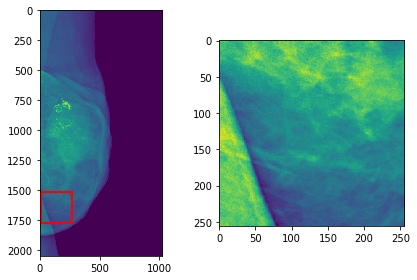

array([23238, 23707, 23186, ..., 13845, 13749, 13696], dtype=uint16)

In [153]:
make_patch_non_cancer(img_file,plot = True)


# create dataset to synthesize


In [ ]:
path = '../dataset/nocancer/'
Z = [] #imreal
from tqdm import tqdm
for c in tqdm(os.listdir(path)):
    print(c.split('-')[0])
    z = make_patch_non_cancer(path+c,False) #boolean to plot
    Z.append(z)
    print(z.shape)


# non_cancer_patches.npz

In [ ]:
np.savez_compressed('../non_cancer_patches', x_real = np.stack(Z))

In [19]:
X = np.load('../non_cancer_patches.npz')['x_real']

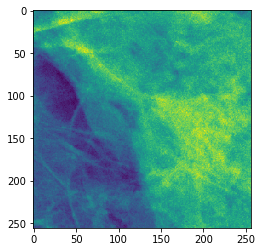

In [20]:
plt.imshow(X[0].reshape(256,256))

### results arch original

In [25]:
loss = np.load('loss_original.npz')
data = [loss[l] for l in loss.files]
print(loss.files)

['vgg', 'boundary', 'l1', 'd', 'g']


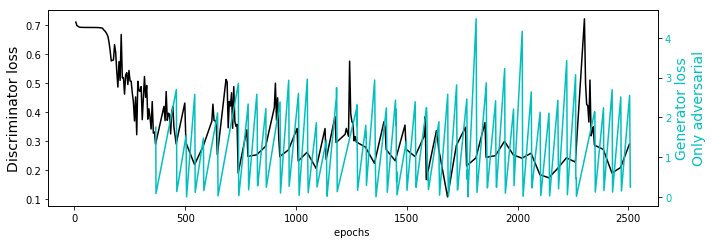

In [26]:

fig, ax1 = plt.subplots(figsize = (10,3.5))

color = 'black'
ax1.set_xlabel('epochs ')
ax1.set_ylabel('Discriminator loss', color=color, fontsize =14)
ax1.plot(data[3][:,0],data[3][:,1],color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'c'
ax2.set_ylabel('Generator loss\nOnly adversarial', color=color,fontsize =14)  # we already handled the x-label with ax1
ax2.plot(data[4][:,0],data[4][:,1],color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()